# PC-Hazard Example 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import PCHazard
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

In [3]:
df_train_x = pd.read_csv('train_x.csv')
df_train_y = pd.read_csv('train_y.csv')
df_train_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [4]:
df_test_x = pd.read_csv('test_x.csv')
df_test_y = pd.read_csv('test_y.csv')
df_test_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [5]:
df_test = pd.concat([df_test_x, df_test_y], axis=1)
df_test = df_test.astype('float32')

In [6]:
df_train = pd.concat([df_train_x, df_train_y], axis=1)
df_train = df_train.astype('float32')

In [7]:
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [8]:
df_train.head()

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,Age,metastasis,secondprim,Status,Survival
0,1.0,2.0,2.0,2.0,6.7,3.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,2.0,75.0,2.0,2.0,1.0,363.0
1,2.0,1.0,2.0,3.0,1.5,2.0,1.0,1.0,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,66.0,2.0,2.0,0.0,10000.0
2,2.0,1.0,3.0,3.0,2.9,3.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,48.0,2.0,2.0,0.0,12.0
3,1.0,2.0,4.0,3.0,4.0,2.0,1.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,65.0,2.0,2.0,0.0,10000.0
4,2.0,2.0,2.0,3.0,3.5,3.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,2.0,2.0,75.0,2.0,2.0,1.0,347.0


## Feature transforms

In [9]:
cols_standardize =  ['BE', 'BC', 'AQ', 'Age'] # Numerical columns
cols_leave = ['Y', 'AF', 'BG', 'BH', 'BI', 'BL',
              'BM', 'BP', 'CY', 'DC', 'DT',
              'DW', 'DX', 'DY', 'metastasis', 'secondprim'] # Binary columns
cols_categorical =  ['AY', 'DE'] # Categorical Columns

print(len(cols_standardize) + len(cols_leave) + len(cols_categorical))

22


In [10]:
# Turn them to binary features (0, 1)
df_train[cols_leave] -= 1
df_val[cols_leave] -= 1
df_test[cols_leave] -= 1

In [11]:
df_train.head(4)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,Age,metastasis,secondprim,Status,Survival
0,0.0,1.0,2.0,2.0,6.7,3.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,75.0,1.0,1.0,1.0,363.0
1,1.0,0.0,2.0,3.0,1.5,2.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,66.0,1.0,1.0,0.0,10000.0
2,1.0,0.0,3.0,3.0,2.9,3.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,48.0,1.0,1.0,0.0,12.0
3,0.0,1.0,4.0,3.0,4.0,2.0,0.0,1.0,1.0,0.0,...,2.0,1.0,1.0,1.0,1.0,65.0,1.0,1.0,0.0,10000.0


In [12]:
# Preprocess different types of features.
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [13]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [14]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [15]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

## Label transforms

In [16]:
num_durations = 20
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df['Survival'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [17]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransPCHazard

## Neural net

In [18]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [19]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

## Training the model

In [20]:
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

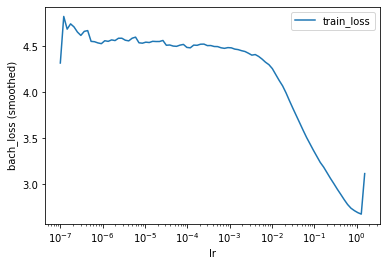

In [21]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()

In [22]:
lr_finder.get_best_lr()

0.12915496650148922

In [23]:
model.optimizer.set_lr(0.01)

In [24]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 4.0879,	val_loss: 3.8009
1:	[0s / 0s],		train_loss: 3.7693,	val_loss: 3.4944
2:	[0s / 0s],		train_loss: 2.7139,	val_loss: 2.9184
3:	[0s / 0s],		train_loss: 2.3781,	val_loss: 2.2627
4:	[0s / 0s],		train_loss: 1.7323,	val_loss: 1.7175
5:	[0s / 0s],		train_loss: 1.3856,	val_loss: 1.4261
6:	[0s / 0s],		train_loss: 0.9565,	val_loss: 1.2657
7:	[0s / 0s],		train_loss: 0.9387,	val_loss: 1.1865
8:	[0s / 0s],		train_loss: 0.7203,	val_loss: 1.1453
9:	[0s / 0s],		train_loss: 0.6519,	val_loss: 1.1115
10:	[0s / 0s],		train_loss: 0.5700,	val_loss: 1.0769
11:	[0s / 0s],		train_loss: 0.6273,	val_loss: 1.0554
12:	[0s / 0s],		train_loss: 0.5550,	val_loss: 1.0382
13:	[0s / 0s],		train_loss: 0.6729,	val_loss: 1.0296
14:	[0s / 0s],		train_loss: 0.4902,	val_loss: 1.0415
15:	[0s / 0s],		train_loss: 0.5117,	val_loss: 1.0450
16:	[0s / 0s],		train_loss: 0.5812,	val_loss: 1.0508
17:	[0s / 0s],		train_loss: 0.4719,	val_loss: 1.0547
18:	[0s / 0s],		train_loss: 0.5157,	val_loss: 1.0689
19:

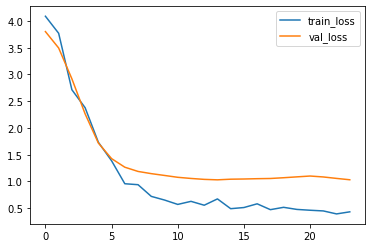

In [25]:
_ = log.plot()

## Prediction

In [26]:
surv = model.predict_surv_df(x_test)

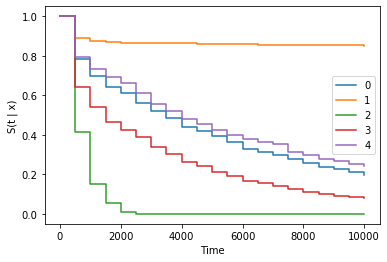

In [27]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [28]:
model.sub = 10

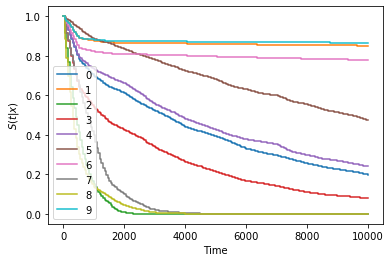

In [29]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('$S(t|x)$')
_ = plt.xlabel('Time')

## Evaluation

In [30]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

In [31]:
ev.concordance_td('antolini')

0.7753275109170306

#### Brier Score

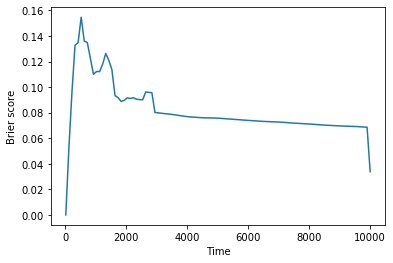

In [32]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Integrated scores

In [33]:
ev.integrated_brier_score(time_grid) 

0.08227753729642495

In [34]:
durations_train, events_train = get_target(df_train)

In [35]:
surv_train = model.predict_surv_df(x_train)

In [36]:
model.sub = 10

In [37]:
ev = EvalSurv(surv_train, durations_train, events_train, censor_surv='km')

In [38]:
ev.concordance_td()

0.8358733103631063

In [39]:
ev.integrated_brier_score(time_grid) 

0.049471925087668324

RuntimeError: We don't allow to plot more than 50 lines. Use e.g. `ev[1:5].plot()`